In [88]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
import seaborn as sns
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [4]:
sqlc

In [5]:
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'mjc7nz/Admission_predict.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pd.read_csv(data_location)
#source: https://www.kaggle.com/mohansacharya/graduate-admissions

Serial_No  GRE_Score  TOEFL_Score  University_Rating  SOP  LOR  CGPA  \
0            1        337          118                  4  4.5  4.5  9.65   
1            2        324          107                  4  4.0  4.5  8.87   
2            3        316          104                  3  3.0  3.5  8.00   
3            4        322          110                  3  3.5  2.5  8.67   
4            5        314          103                  2  2.0  3.0  8.21   
5            6        330          115                  5  4.5  3.0  9.34   
6            7        321          109                  3  3.0  4.0  8.20   
7            8        308          101                  2  3.0  4.0  7.90   
8            9        302          102                  1  2.0  1.5  8.00   
9           10        323          108                  3  3.5  3.0  8.60   
10          11        325          106                  3  3.5  4.0  8.40   
11          12        327          111                  4  4.0  4.5  9.00   
12          13        328          112                  4  4.0  4.5  9.10   
13          14        307          109                  3  4.0  3.0  8.00   
14          15        311          104                  3  3.5  2.0  8.20   
15          16        314          105                  3  3.5  2.5  8.30   
16          17        317          107                  3  4.0  3.0  8.70   
17          18        319          106                  3  4.0  3.0  8.00   
18          19        318          110                  3  4.0  3.0  8.80   
19          20        303          102                  3  3.5  3.0  8.50   
20          21        312          107                  3  3.0  2.0  7.90   
21          22        325          114                  4  3.0  2.0  8.40   
22          23        328          116                  5  5.0  5.0  9.50   
23          24        334          119                  5  5.0  4.5  9.70   
24          25        336          119                  5  4.0  3.5  9.80   
25          26        340          120                  5  4.5  4.5  9.60   
26          27        322          109                  5  4.5  3.5  8.80   
27          28        298           98                  2  1.5  2.5  7.50   
28          29        295           93                  1  2.0  2.0  7.20   
29          30        310           99                  2  1.5  2.0  7.30   
..         ...        ...          ...                ...  ...  ...   ...   
470        471        320          110                  5  4.0  4.0  9.27   
471        472        311          103                  3  2.0  4.0  8.09   
472        473        327          116                  4  4.0  4.5  9.48   
473        474        316          102                  2  4.0  3.5  8.15   
474        475        308          105                  4  3.0  2.5  7.95   
475        476        300          101                  3  3.5  2.5  7.88   
476        477        304          104                  3  2.5  2.0  8.12   
477        478        309          105                  4  3.5  2.0  8.18   
478        479        318          103                  3  4.0  4.5  8.49   
479        480        325          110                  4  4.5  4.0  8.96   
480        481        321          102                  3  3.5  4.0  9.01   
481        482        323          107                  4  3.0  2.5  8.48   
482        483        328          113                  4  4.0  2.5  8.77   
483        484        304          103                  5  5.0  3.0  7.92   
484        485        317          106                  3  3.5  3.0  7.89   
485        486        311          101                  2  2.5  3.5  8.34   
486        487        319          102                  3  2.5  2.5  8.37   
487        488        327          115                  4  3.5  4.0  9.14   
488        489        322          112                  3  3.0  4.0  8.62   
489        490        302          110                  3  4.0  4.5  8.50   
4

In [6]:
df = sqlc.createDataFrame(pd.read_csv(data_location))
df

DataFrame[Serial_No: bigint, GRE_Score: bigint, TOEFL_Score: bigint, University_Rating: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Chance_of_Admit: double]

In [ ]:
parquetPath = '/home/ec2-user/SageMaker/tmp-pqt-mjc7nz'
df.write.parquet(parquetPath)

In [8]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "Admission_predict/pqt/"+f)

In [9]:
df = sqlc.read.parquet(parquetPath)
df

DataFrame[Serial_No: bigint, GRE_Score: bigint, TOEFL_Score: bigint, University_Rating: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Chance_of_Admit: double]

In [10]:
df.printSchema()

root
 |-- Serial_No: long (nullable = true)
 |-- GRE_Score: long (nullable = true)
 |-- TOEFL_Score: long (nullable = true)
 |-- University_Rating: long (nullable = true)
 |-- SOP: double (nullable = true)
 |-- LOR: double (nullable = true)
 |-- CGPA: double (nullable = true)
 |-- Research: long (nullable = true)
 |-- Chance_of_Admit: double (nullable = true)



In [11]:
df = df.drop("Serial_No")
df

DataFrame[GRE_Score: bigint, TOEFL_Score: bigint, University_Rating: bigint, SOP: double, LOR: double, CGPA: double, Research: bigint, Chance_of_Admit: double]

In [12]:
#summary statistics
df.describe().show()

+-------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|summary|         GRE_Score|      TOEFL_Score|University_Rating|               SOP|               LOR|              CGPA|          Research|    Chance_of_Admit|
+-------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|  count|               500|              500|              500|               500|               500|               500|               500|                500|
|   mean|           316.472|          107.192|            3.114|             3.374|             3.484| 8.576440000000003|              0.56| 0.7217399999999996|
| stddev|11.295148372354712|6.081867659564538|1.143511800759815|0.9910036207566072|0.9254495738978191|0.6048128003332054|0.4968840786090358|0.14114040395030228|
|    min|               290|      

In [13]:
#correlation matrix
col_names = df.columns
features = df.rdd.map(lambda row: row[0:])
corr_mat = Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names
print(corr_df)

                   GRE_Score  TOEFL_Score  University_Rating       SOP  \
GRE_Score           1.000000     0.827200           0.635376  0.613498   
TOEFL_Score         0.827200     1.000000           0.649799  0.644410   
University_Rating   0.635376     0.649799           1.000000  0.728024   
SOP                 0.613498     0.644410           0.728024  1.000000   
LOR                 0.524679     0.541563           0.608651  0.663707   
CGPA                0.825878     0.810574           0.705254  0.712154   
Research            0.563398     0.467012           0.427047  0.408116   
Chance_of_Admit     0.810351     0.792228           0.690132  0.684137   

                        LOR      CGPA  Research  Chance_of_Admit  
GRE_Score          0.524679  0.825878  0.563398         0.810351  
TOEFL_Score        0.541563  0.810574  0.467012         0.792228  
University_Rating  0.608651  0.705254  0.427047         0.690132  
SOP                0.663707  0.712154  0.408116         0.684137 

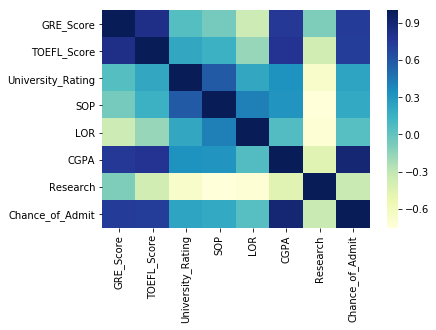

In [89]:
corr = corr_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap="YlGnBu")

In [14]:
# create train/test sets
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=50)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 401, test set N = 99


In [15]:
# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("Chance_of_Admit", "oneElementVec(GRE_Score) as GRE_Score")
testDF = testDF.selectExpr("Chance_of_Admit", "oneElementVec(GRE_Score) as GRE_Score")

# rename
trainingDF = trainingDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("GRE_Score", "features")
testDF = testDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("GRE_Score", "features")

print(testDF.orderBy(testDF.label.desc()).limit(5))

DataFrame[label: double, features: vector]


In [16]:
lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [17]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=0.97, features=DenseVector([334.0]), prediction=0.899355285079289), Row(label=0.96, features=DenseVector([339.0]), prediction=0.9502669335219869), Row(label=0.96, features=DenseVector([333.0]), prediction=0.8891729553907495), Row(label=0.95, features=DenseVector([334.0]), prediction=0.899355285079289), Row(label=0.94, features=DenseVector([331.0]), prediction=0.8688082960136705)]


In [18]:
eval = RegressionEvaluator()
GRE_Score_rmse = eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)
GRE_Score_rmse

0.0771223835600536

In [19]:
GRE_Score_r2 = eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)
GRE_Score_r2

0.6423615494455245

In [20]:
#test TOEFL_Score
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=50)
trainingDF = trainingDF.selectExpr("Chance_of_Admit", "oneElementVec(TOEFL_Score) as TOEFL_Score")
testDF = testDF.selectExpr("Chance_of_Admit", "oneElementVec(TOEFL_Score) as TOEFL_Score")
trainingDF = trainingDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("TOEFL_Score", "features")
testDF = testDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("TOEFL_Score", "features")
lrModel = lr.fit(trainingDF)
predictionsAndLabelsDF = lrModel.transform(testDF)
TOEFL_Score_rmse = eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)
TOEFL_Score_rmse

0.08093980947810228

In [21]:
TOEFL_Score_r2 = eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)
TOEFL_Score_r2

0.6060803247328955

In [22]:
#test University Rating
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=50)
trainingDF = trainingDF.selectExpr("Chance_of_Admit", "oneElementVec(University_Rating) as University_Rating")
testDF = testDF.selectExpr("Chance_of_Admit", "oneElementVec(University_Rating) as University_Rating")
trainingDF = trainingDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("University_Rating", "features")
testDF = testDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("University_Rating", "features")
lrModel = lr.fit(trainingDF)
predictionsAndLabelsDF = lrModel.transform(testDF)
University_Rating_rmse = eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)
University_Rating_rmse

0.08912862784167866

In [23]:
University_Rating_r2 = eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)
University_Rating_r2

0.5223412270351414

In [24]:
#test SOP
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=50)
trainingDF = trainingDF.selectExpr("Chance_of_Admit", "oneElementVec(SOP) as SOP")
testDF = testDF.selectExpr("Chance_of_Admit", "oneElementVec(SOP) as SOP")
trainingDF = trainingDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("SOP", "features")
testDF = testDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("SOP", "features")
lrModel = lr.fit(trainingDF)
predictionsAndLabelsDF = lrModel.transform(testDF)
SOP_rmse = eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)
SOP_rmse

0.10128209557311305

In [25]:
SOP_r2 = eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)
SOP_r2

0.3831938792381374

In [26]:
#test LOR
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=50)
trainingDF = trainingDF.selectExpr("Chance_of_Admit", "oneElementVec(LOR) as LOR")
testDF = testDF.selectExpr("Chance_of_Admit", "oneElementVec(LOR) as LOR")
trainingDF = trainingDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("LOR", "features")
testDF = testDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("LOR", "features")
lrModel = lr.fit(trainingDF)
predictionsAndLabelsDF = lrModel.transform(testDF)
LOR_rmse = eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)
LOR_rmse

0.1011407002032424

In [27]:
LOR_r2 = eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)
LOR_r2

0.3849148675658578

In [28]:
#test CGPA
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=50)
trainingDF = trainingDF.selectExpr("Chance_of_Admit", "oneElementVec(CGPA) as CGPA")
testDF = testDF.selectExpr("Chance_of_Admit", "oneElementVec(CGPA) as CGPA")
trainingDF = trainingDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("CGPA", "features")
testDF = testDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("CGPA", "features")
lrModel = lr.fit(trainingDF)
predictionsAndLabelsDF = lrModel.transform(testDF)
CGPA_rmse = eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)
CGPA_rmse

0.06534229796503434

In [29]:
CGPA_r2 = eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)
CGPA_r2

0.743272657581504

In [30]:
#test Research
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=50)
trainingDF = trainingDF.selectExpr("Chance_of_Admit", "oneElementVec(Research) as Research")
testDF = testDF.selectExpr("Chance_of_Admit", "oneElementVec(Research) as Research")
trainingDF = trainingDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("Research", "features")
testDF = testDF.withColumnRenamed("Chance_of_Admit", "label").withColumnRenamed("Research", "features")
lrModel = lr.fit(trainingDF)
predictionsAndLabelsDF = lrModel.transform(testDF)
Research_rmse = eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)
Research_rmse

0.1104140463514662

In [31]:
Research_r2 = eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)
Research_r2

0.2669527493142435

In [90]:
#RMSE dataframe
RMSE = {'feature': ('GRE_Score', 'TOEFL_Score', 'University_Rating','SOP','LOR','CGPA','Research'), 'rmse': pd.Series([float(GRE_Score_rmse), float(TOEFL_Score_rmse), float(University_Rating_rmse), float(SOP_rmse), float(LOR_rmse), float(CGPA_rmse), float(Research_rmse)])}
RMSE = pd.DataFrame(RMSE)
RMSE

feature      rmse
0          GRE_Score  0.077122
1        TOEFL_Score  0.080940
2  University_Rating  0.089129
3                SOP  0.101282
4                LOR  0.101141
5               CGPA  0.065342
6           Research  0.110414

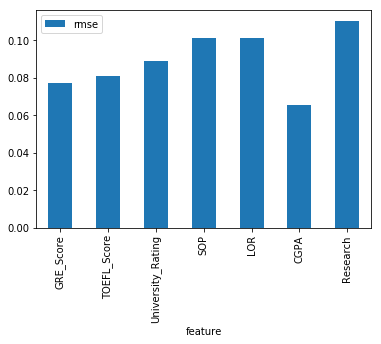

In [84]:
#RMSE plot
RMSE.plot.bar(x='feature')

In [83]:
#R2 dataframe
R2 = {'feature': ('GRE_Score', 'TOEFL_Score', 'University_Rating','SOP','LOR','CGPA','Research'), 'r2': pd.Series([float(GRE_Score_r2), float(TOEFL_Score_r2), float(University_Rating_r2), float(SOP_r2), float(LOR_r2), float(CGPA_r2), float(Research_r2)])}
R2 = pd.DataFrame(R2)
R2

feature        r2
0          GRE_Score  0.642362
1        TOEFL_Score  0.606080
2  University_Rating  0.522341
3                SOP  0.383194
4                LOR  0.384915
5               CGPA  0.743273
6           Research  0.266953

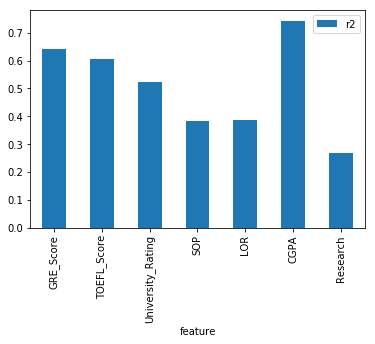

In [85]:
#R2 plot
R2.plot.bar(x='feature')